In [136]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

### Definition of the model

In [137]:
# The SIR model differential equations.
def deriv(y, t, N, beta,gamma):
    S,I,R = y

    dSdt = -(beta*I/N)*S 
    dIdt = (beta*S/N)*I - gamma*I 
    dRdt = gamma*I 
    
    return dSdt, dIdt, dRdt

### Integration of the differential equations

In [138]:
def time_evo(N,beta,gamma,I0=1,R0=0,t=np.arange(0,365)):
    # Definition of the initial conditions
    # I0 and R0 denotes the number of initial infected people (I0) 
    # and the number of people that recovered and are immunized (R0)
    
    # t ise the timegrid
    
    S0=N-I0-R0  # number of people that can still contract the virus
    
    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N,beta,gamma))
    S, I, R = np.transpose(ret)
    
    return (t,S,I,R)

### Show the result

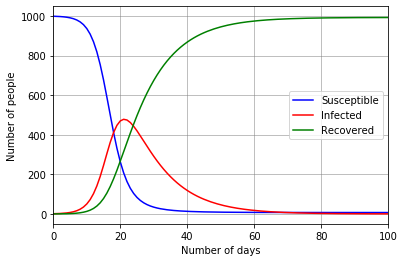

In [139]:
fin_result=time_evo(1000,0.5,0.1)

t=fin_result[0]
s_vec=fin_result[1]
i_vec=fin_result[2]
r_vec=fin_result[3]

plt.plot(t, s_vec, 'b', label='Susceptible')
plt.plot(t, i_vec, 'r', label='Infected')
plt.plot(t, r_vec, 'g', label='Recovered')
#plt.plot(t, m_vec, 'k', label='Deaths')
#plt.plot(t, i_vec+r_vec, color='orange',linestyle='--', label='Infected + Recovered')
plt.legend(loc=5)
#plt.yscale('log')
#plt.ylim(0.5,3000)
plt.xlim(0,100)
plt.xlabel('Number of days')
plt.ylabel('Number of people')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.savefig('plotsir05.png',dpi=300)
plt.show()

#print(s_vec+i_vec+r_vec+m_vec)

### Load italian data

In [140]:
scelta='nazionale'

if scelta=='nazionale':
    data = pd.read_csv('https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
    xdata=pd.to_numeric(range(data.shape[0]))
    ydata=data['totale_casi']
    ydata_death=data['deceduti']
    ydata_rec=data['dimessi_guariti']
    ydata_inf=ydata-ydata_rec-ydata_death

elif scelta=='regionale':
    datatot = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')
    mask = datatot['denominazione_regione']=='Molise'
    data =datatot.loc[mask,:]
    xdata=pd.to_numeric(range(data.shape[0]))
    ydata=data['totale_casi']
    ydata_death=data['deceduti']
    ydata_rec=data['dimessi_guariti']
    ydata_inf=np.array(ydata-ydata_death-ydata_rec)
    
data.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,7,229,4324,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,10,322,8623,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,12,400,9587,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,17,650,12014,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,21,888,15695,NaN,NaN


In [141]:
data.iloc[-1]

data                          2020-04-14T17:00:00
stato                                         ITA
ricoverati_con_sintomi                      28011
terapia_intensiva                            3186
totale_ospedalizzati                        31197
isolamento_domiciliare                      73094
totale_positivi                            104291
variazione_totale_positivi                    675
nuovi_positivi                               2972
dimessi_guariti                             37130
deceduti                                    21067
totale_casi                                162488
tamponi                                   1073689
note_it                                       NaN
note_en                                       NaN
Name: 50, dtype: object

# comparison between model and data

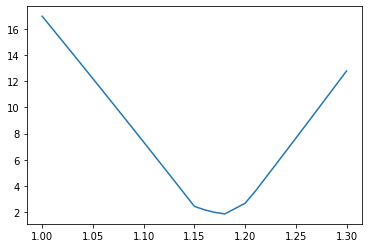

In [142]:
today=len(xdata)

def minimizer(R0,t1=today-5,t2=today):
    
    #true data
    ydata_inf_2=np.array(ydata_inf[t1:t2])
    xdata_2=np.arange(0,len(ydata_inf_2))
    
    #model
    fin_result=time_evo(60*10**6,0.1*R0,0.1,I0=ydata_inf_2[0])
    i_vec=fin_result[2]
    i_vec_2=i_vec[0:len(xdata_2)]
    
    #average error
    error=np.sum(np.abs(ydata_inf_2-i_vec_2)/ydata_inf_2)*100
    
    return error

minimizer_vec=np.vectorize(minimizer)


#definition of the ideal r0

xgrid=np.arange(1,1.3,0.01)
ygrid=minimizer_vec(xgrid)
r0_ideal=round(xgrid[np.argmin(ygrid)],2)
r0_ideal

plt.plot(xgrid,ygrid)
plt.show()

### model for the italian situation

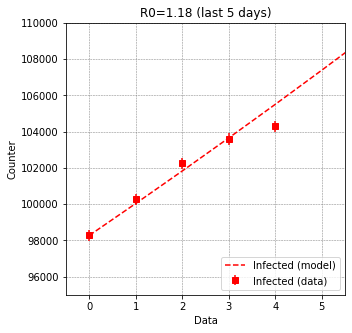

In [143]:
ydata_inf_2=np.array(ydata_inf[today-5:today])
xdata_2=np.arange(0,len(ydata_inf_2))

fin_result=time_evo(60*10**6,0.1*r0_ideal,0.1,I0=ydata_inf_2[0])

t=fin_result[0]
s_vec=fin_result[1]
i_vec=fin_result[2]
r_vec=fin_result[3]

plt.figure(figsize=(5,5))
plt.errorbar(xdata_2,ydata_inf_2,np.sqrt(ydata_inf_2),color='red',linestyle='None',marker='s',label='Infected (data)')
plt.plot(t, i_vec, 'r--', label='Infected (model)')
#plt.yscale('log')
#plt.xticks(np.arange(14,70,7),['21 Feb','28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr'],rotation=30)
plt.xlim(-0.5,5.5)
plt.ylim(9.5*10**4,1.1*10**5)
#plt.ylim(150,230)
plt.xlabel('Data')
plt.ylabel('Counter')
plt.legend(loc=4)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.title('R0='+str(r0_ideal)+' (last 5 days)')
plt.savefig('output/r0-5days.png',dpi=300)
plt.show()

### scan di R0 nel corso del tempo

In [144]:
time_window=5

def minimizer_gen(t1,t2):

    xgrid=np.arange(1,5,0.01)
    ygrid=minimizer_vec(xgrid,t1=t1,t2=t2)
    r0_ideal=round(xgrid[np.argmin(ygrid)],2)

    return r0_ideal

r0_time=[]

for i in range(today-(time_window-1)):
    min_val=minimizer_gen(i,i+time_window)
    r0_time.append(min_val)
    print(i,min_val)
    
r0_time=np.array(r0_time)

0 4.27
1 4.04
2 4.52
3 3.89
4 3.54
5 3.56
6 2.81
7 2.94
8 2.88
9 3.09
10 3.21
11 3.37
12 2.85
13 2.69
14 2.57
15 2.88
16 2.72
17 2.53
18 2.44
19 2.28
20 2.18
21 2.22
22 2.23
23 2.32
24 2.13
25 1.95
26 1.79
27 1.71
28 1.69
29 1.66
30 1.66
31 1.58
32 1.43
33 1.35
34 1.29
35 1.31
36 1.32
37 1.31
38 1.3
39 1.29
40 1.21
41 1.15
42 1.13
43 1.15
44 1.17
45 1.17
46 1.18


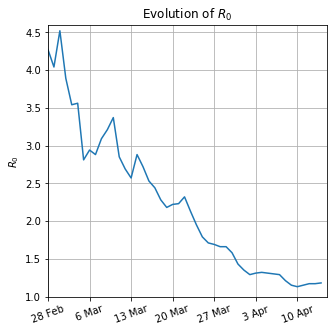

In [145]:
plt.figure(figsize=(5,5))
plt.plot(r0_time)
plt.xticks(np.arange(0-(time_window-5),55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
plt.xlim(0,today-4)
plt.ylabel('$R_0$')
plt.ylim(1,4.6)
plt.grid()
plt.title('Evolution of $R_0$')
plt.savefig('output/r0-evo.png',dpi=300)
plt.show()

In [146]:
df_r0=pd.DataFrame(pd.to_datetime(np.arange(len(r0_time)),unit='D',origin='2020-02-28'))
df_r0['R0']=r0_time
df_r0.columns=['Data','R0']

In [147]:
df_r0.to_csv('output/r0.csv',index=False)

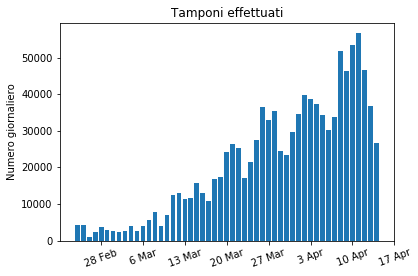

In [148]:
data_tamponi=np.array(data['tamponi'])
incr_tamponi=[data_tamponi[0]]

for i in range(len(data_tamponi)-1):
    incr_tamponi.append(data_tamponi[i+1]-data_tamponi[i])

plt.bar(np.arange(len(incr_tamponi)),incr_tamponi)
plt.xticks(np.arange(4,55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
plt.ylabel('Numero giornaliero')
plt.title('Tamponi effettuati')
plt.show()

### caso regionale (Molise)

In [149]:
if scelta=='regionale':
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(ydata_inf)
    plt.xticks(np.arange(4,55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
    plt.ylabel('Numero totale')
    plt.title('Infetti attivi')
    plt.subplot(1,3,2)
    plt.plot(r0_time)
    plt.xticks(np.arange(0-(time_window-5),55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
    plt.xlim(0,today-7)
    plt.ylabel('$R_0$')
    plt.ylim(1,3.2)
    plt.grid()
    plt.title('Evoluzione del parametro $R_0$ in Molise')
    plt.subplot(1,3,3)
    plt.bar(np.arange(len(incr_tamponi)),incr_tamponi)
    plt.xticks(np.arange(4,55,7),['28 Feb','6 Mar','13 Mar','20 Mar','27 Mar','3 Apr','10 Apr','17 Apr'],rotation=20)
    plt.ylabel('Numero giornaliero')
    plt.title('Tamponi effettuati')
    plt.tight_layout()
    plt.savefig('output/r0-evo-Molise.png',dpi=300)
    plt.show()
else:
    print('Regional plot not available. Please change the choice of the parameter scelta in scelta=regionale')

Regional plot not available. Please change the choice of the parameter scelta in scelta=regionale
